<a href="https://colab.research.google.com/github/sukhum29/Hacknova/blob/main/Music_Database_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'million-song-dataset-spotify-lastfm:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3166258%2F5485048%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T191508Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da20b9607265b40f006348f065d3cfe573d2b74f51a72f93291d0bd1901d9757838f03b2a9ab9dc00003dc8f06e1b081108da3453ede4faae85160c8fa849987b06bc9cdb17e78b7d71ff1b1d1084a4176123dbd6a036b6a6d85952c4c40bc9b4dc136a6cda4a11d3a0d0dde709c05cf536a275df275caea5b8303007a63e65fb518eb50da26228d16114bdc418d7aac2b7d625915c800e0572dea4524b09d4486d17bc9e2cc22b7294f73c8244559f3ee57bef9897fe5e2171a9f0d007e397fa2e7637ad4bc864fd15390b6b27d64926b1f3eed34a0bb773d1360189abb1e39cda38dc0443b35f2e520a6011386be519a071a070bf3e04b4de4bec4a06e5f3a5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 670020079 bytes downloaded
Downloaded and uncompressed: million-song-dataset-spotify-lastfm
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os



In [4]:
music_info = pd.read_csv('../input/million-song-dataset-spotify-lastfm/Music Info.csv')
music_info.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


In [5]:
listening_info = pd.read_csv('../input/million-song-dataset-spotify-lastfm/User Listening History.csv')
listening_info.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [6]:
music_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             50683 non-null  object 
 1   name                 50683 non-null  object 
 2   artist               50683 non-null  object 
 3   spotify_preview_url  50683 non-null  object 
 4   spotify_id           50683 non-null  object 
 5   tags                 49556 non-null  object 
 6   genre                22348 non-null  object 
 7   year                 50683 non-null  int64  
 8   duration_ms          50683 non-null  int64  
 9   danceability         50683 non-null  float64
 10  energy               50683 non-null  float64
 11  key                  50683 non-null  int64  
 12  loudness             50683 non-null  float64
 13  mode                 50683 non-null  int64  
 14  speechiness          50683 non-null  float64
 15  acousticness         50683 non-null 

In [7]:
listening_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9711301 entries, 0 to 9711300
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   track_id   object
 1   user_id    object
 2   playcount  int64 
dtypes: int64(1), object(2)
memory usage: 222.3+ MB


By joining these two DataFrames, using *track_id* as our index, we can make relational analyses.

In [8]:
left = music_info.set_index('track_id')
right = listening_info.set_index('track_id')
music_listening_info = left.join(right)
music_listening_info.head()

,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,user_id,playcount
track_id,,,,,,,,,,,,,,,,,,,,,
TRAAADT12903CCC339,Andalucia,Pink Martini,https://p.scdn.co/mp3-preview/37d9c700532305fc...,16uYYyMYpiJsUC9JzZX4Zk,"jazz, french, lounge",NaN,1997,219360,0.714,0.521,...,1,0.0363,0.727,0.825000,0.074,0.683,92.530,3,NaN,NaN
TRAAAED128E0783FAB,It's About Time,Jamie Cullum,https://p.scdn.co/mp3-preview/9bb7b58f848a742b...,00ZCW9lUa2bqwpF6rhtaMI,"jazz, piano, chill",Jazz,2004,247000,0.565,0.507,...,1,0.0541,0.702,0.000066,0.129,0.454,152.462,4,cf7bd4b5b398b3e150cf262d79147312a69b96ac,9.0
TRAAAED128E0783FAB,It's About Time,Jamie Cullum,https://p.scdn.co/mp3-preview/9bb7b58f848a742b...,00ZCW9lUa2bqwpF6rhtaMI,"jazz, piano, chill",Jazz,2004,247000,0.565,0.507,...,1,0.0541,0.702,0.000066,0.129,0.454,152.462,4,043d81932e75d5749ed5758d6420506e7bc457a5,3.0
TRAAAED128E0783FAB,It's About Time,Jamie Cullum,https://p.scdn.co/mp3-preview/9bb7b58f848a742b...,00ZCW9lUa2bqwpF6rhtaMI,"jazz, piano, chill",Jazz,2004,247000,0.565,0.507,...,1,0.0541,0.702,0.000066,0.129,0.454,152.462,4,515e1ab04c00859de983cacf35f150f2ddb37dde,1.0
TRAAAED128E0783FAB,It's About Time,Jamie Cullum,https://p.scdn.co/mp3-preview/9bb7b58f848a742b...,00ZCW9lUa2bqwpF6rhtaMI,"jazz, piano, chill",Jazz,2004,247000,0.565,0.507,...,1,0.0541,0.702,0.000066,0.129,0.454,152.462,4,e49ac0612b9444abf3d513e54b1cd77f6fe5ae4b,1.0


In [9]:
music_listening_info.describe()
music_numeric = music_info.select_dtypes(include=[np.number]).dropna()
features = ['energy', 'key', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-025c5d904b49>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = music_info.groupby('Cluster').mean()


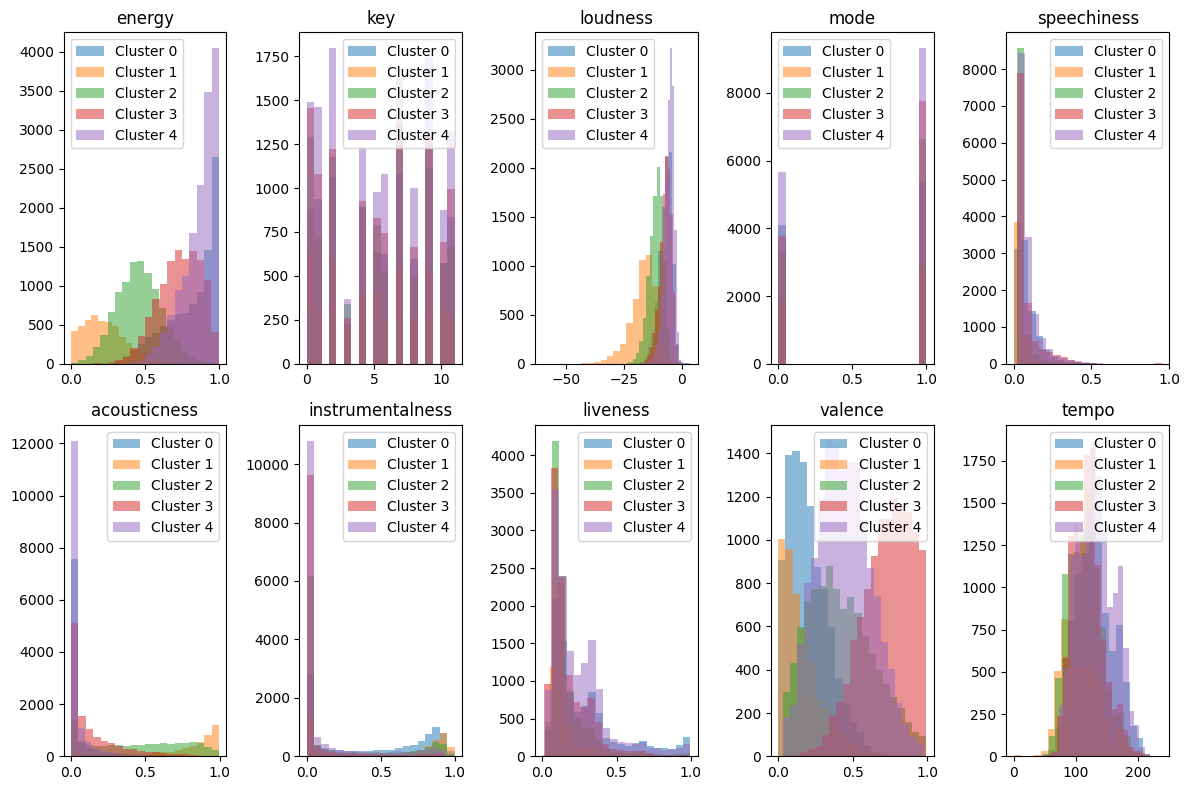

In [10]:
scaler = StandardScaler()
music_scaled = scaler.fit_transform(music_numeric)


pca = PCA(n_components=2)
music_pca = pca.fit_transform(music_scaled)


kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(music_pca)


music_info['Cluster'] = clusters
cluster_means = music_info.groupby('Cluster').mean()


plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 5, i + 1)
    for cluster in range(5):
        plt.hist(music_info[music_info['Cluster'] == cluster][feature], bins=20, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def calculate_similarity_index(song1, song2):
    similarity = 0
    for feature in features:
        hist1, _ = np.histogram(song1[feature], bins=20, density=True)
        hist2, _ = np.histogram(song2[feature], bins=20, density=True)
        similarity += np.linalg.norm(hist1 - hist2)
    return similarity / len(features)


song1 = music_info.iloc[0]
song2 = music_info.iloc[10]
similarity_index = calculate_similarity_index(song1, song2)
print("Similarity Index between Song 1 and Song 2:", similarity_index)

Similarity Index between Song 1 and Song 2: 8.485281374239145


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = np.random.rand(1000, 10)
y = np.random.randint(2, size=(1000,))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_siamese_network(input_shape):
    input_left = Input(shape=input_shape)
    input_right = Input(shape=input_shape)


    shared_embedding = tf.keras.Sequential([
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu')
    ])


    encoded_left = shared_embedding(input_left)
    encoded_right = shared_embedding(input_right)


    concatenated = Concatenate()([encoded_left, encoded_right])


    output = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[input_left, input_right], outputs=output)
    return model


siamese_model = create_siamese_network(input_shape=X_train.shape[1])


siamese_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss=BinaryCrossentropy(),
                      metrics=[BinaryAccuracy()])


siamese_model.fit([X_train, X_train], y_train,
                  validation_data=([X_test, X_test], y_test),
                  epochs=10, batch_size=32)

loss, accuracy = siamese_model.evaluate([X_test, X_test], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


y_pred = siamese_model.predict([X_test, X_test])


y_pred_binary = np.round(y_pred).flatten()


print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))


roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC Score: {roc_auc:.4f}')


Epoch 1/10
25/25 [==============================] - 3s 23ms/step - loss: 0.6942 - binary_accuracy: 0.4700 - val_loss: 0.6933 - val_binary_accuracy: 0.4650
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6931 - binary_accuracy: 0.5075 - val_loss: 0.6935 - val_binary_accuracy: 0.4650
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6931 - binary_accuracy: 0.5075 - val_loss: 0.6935 - val_binary_accuracy: 0.4650
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 0.6930 - binary_accuracy: 0.5075 - val_loss: 0.6951 - val_binary_accuracy: 0.4700
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.6929 - binary_accuracy: 0.5063 - val_loss: 0.6982 - val_binary_accuracy: 0.4650
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 0.6921 - binary_accuracy: 0.5075 - val_loss: 0.6975 - val_binary_accuracy: 0.4650
Epoch 7/10
25/25 [==============================] - 0s 8ms/step - loss: 0.

In [19]:
import tensorflow as tf
import tensorflow.keras.backend as K

# Define a function to find the most similar songs to a given song
def find_most_similar_songs(reference_song, song_list, model, top_n=5):
    # Create an empty list to store similarity scores
    similarity_scores = []

    # Iterate over each song in the song list
    for idx, song in song_list.iterrows():
        # Calculate similarity index between the reference song and the current song
        similarity_score = calculate_similarity_index(reference_song, song, model)

        # Append the similarity score along with the index of the song
        similarity_scores.append((idx, similarity_score))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the indices of the top N most similar songs
    top_indices = [idx for idx, _ in similarity_scores[:top_n]]

    return top_indices

# Define a function to calculate the similarity index between two songs
def calculate_similarity_index(song1, song2, model):
    # Extract features from songs
    features_song1 = song1[features]
    features_song2 = song2[features]

    # Reshape features for model input
    features_song1 = np.float32(features_song1)
    features_song2 = np.float32(features_song2)

    # Compute similarity score using the Siamese network model
    similarity_score = model.predict([features_song1, features_song2])[0][0]

    return float(similarity_score)

# Iterate over the first 300 songs in the dataset
reference_song = music_info.iloc[0]
song_list = music_info.iloc[1:301]  # Exclude the first song since it's the same as the reference song
most_similar_song_indices = find_most_similar_songs(reference_song, song_list, siamese_model)

# Print the indices of the top 5 most similar songs
print("Indices of the top 5 most similar songs:", most_similar_song_indices)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


In [ ]:
def get_discography(artist_name):
    discography = music_info.loc[music_info.artist == artist_name]
    return discography

search = get_discography('Radiohead')
search.head()

2. Searching by tags

In [ ]:
def get_tags(tags):
    search = music_info.loc[music_info.tags.isin(tags)]
    #search = music_info.tags.str.contains(tags)
    return search

search = get_tags(['electronic', 'alternative'])
search.head()

3. Searching by track_id

In [ ]:
def get_song_info(id):
    artist = music_info.loc[music_info.track_id == id].artist
    name = music_info.loc[music_info.track_id == id].name
    info = pd.merge(artist, name, right_index=True, left_index=True)
    return info

track_id = 'TRLNZBD128F935E4D8'
get_song_info(track_id)

In [ ]:
# Define a function to take user inputs for the reference song features
def get_user_input():
    print("Enter the features of the reference song:")
    reference_song = {}
    reference_song['name'] = input("Enter the name of the song: ")
    reference_song['genre'] = input("Enter the genre of the song: ")
    reference_song['loudness'] = float(input("Enter the loudness of the song (in dB): "))
    return reference_song

# Get user inputs for the reference song features
reference_song_features = get_user_input()

# Define a default dictionary for missing features
default_features = {
    'energy': 0.5,
    'key': 0,
    'mode': 0,
    'speechiness': 0,
    'acousticness': 0.5,
    'instrumentalness': 0,
    'liveness': 0.5,
    'valence': 0.5,
    'tempo': 120
}

# Fill missing features with default values
for feature, default_value in default_features.items():
    if feature not in reference_song_features:
        reference_song_features[feature] = default_value

# Convert the user inputs into a pandas DataFrame
reference_song_df = pd.DataFrame([reference_song_features])

# Find the most similar songs to the user-input reference song
most_similar_song_indices = find_most_similar_songs(reference_song_df, music_info.iloc[1:301], siamese_model)

# Print the indices of the top 5 most similar songs
print("Indices of the top 5 most similar songs:", most_similar_song_indices)



In [ ]:
track_id_playcount = listening_info.groupby('track_id').playcount.agg(['count', 'sum'])
top_ten_id = track_id_playcount.nlargest(10, 'sum')
#top_ten_tracks = top_ten_id.apply(lambda n : get_song_info(n))
print(top_ten_id)